In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("gpu is available")
else:
    device = torch.device("cpu")
    print("gpu not available,cpu used")

gpu is available


In [6]:
dataset_csv = './IMDB Dataset.csv'

In [7]:
df = pd.read_csv(dataset_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# make x = df['reviews].values and y  = df['sentiment'].values

X,Y = df['review'].values, df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,Y,stratify=Y)

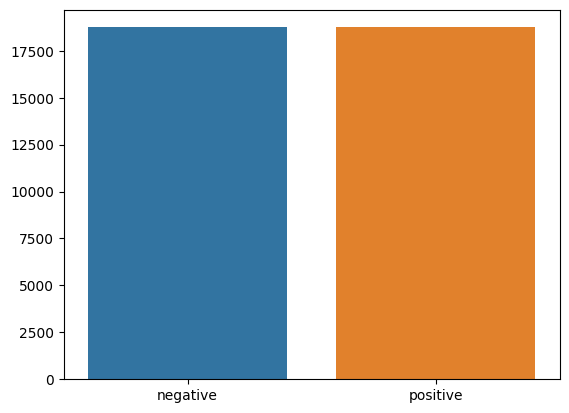

In [9]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [10]:
#Tokenization and natural language processing

In [11]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # Replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

def pad_sequences_custom(sequences, maxlen=None, padding='post', value=0):
    if maxlen is None:
        maxlen = max(len(seq) for seq in sequences)
    
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            if padding == 'post':
                padded_seq = seq + [value] * (maxlen - len(seq))
            elif padding == 'pre':
                padded_seq = [value] * (maxlen - len(seq)) + seq
        else:
            padded_seq = seq[:maxlen]
        padded_sequences.append(padded_seq)
    
    return padded_sequences

def tokenize(x_train, y_train, x_val, y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # Creating a dict
    onehot_dict = {w: i+1 for i, w in enumerate(corpus_)}
    
    # Tokenize
    final_list_train, final_list_test = [], []
    for sent in x_train:
        final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                 if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
        final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                if preprocess_string(word) in onehot_dict.keys()])
    
    # Padding sequences to the same length
    max_length = max(max(len(seq) for seq in final_list_train), max(len(seq) for seq in final_list_test))
    final_list_train = pad_sequences_custom(final_list_train, maxlen=max_length, padding='post')
    final_list_test = pad_sequences_custom(final_list_test, maxlen=max_length, padding='post')
    
    encoded_train = [1 if label == 'positive' else 0 for label in y_train]  
    encoded_test = [1 if label == 'positive' else 0 for label in y_val] 
    
    return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict

 

In [12]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

In [13]:
#create tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))


#dataloaders
batch_size = 50

#make sure to SHUFFLE your data
train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(test_data,shuffle=True,batch_size=batch_size)

In [16]:
datiter = iter(train_loader)
sample_x,sample_y = next(datiter)

sample_x

tensor([[ 65,   3, 106,  ...,   0,   0,   0],
        [266, 238, 513,  ...,   0,   0,   0],
        [464, 259, 258,  ...,   0,   0,   0],
        ...,
        [  4, 273,  22,  ...,   0,   0,   0],
        [  2, 160,  90,  ...,   0,   0,   0],
        [ 14,  54,  96,  ...,   0,   0,   0]], dtype=torch.int32)

In [17]:
sample_y

tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0], dtype=torch.int32)

In [18]:
#Model RNN WITH LSTM LAYERS

SyntaxError: incomplete input (1966852000.py, line 1)

In [20]:
class sentimentrnn(nn.Module):
    def __init__(self, no_layers, vocab_size, hid_dim, emb_dim, output_dim, drop_prob=0.5):
        super(sentimentrnn, self).__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=no_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(self.hid_dim, output_dim)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hid_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers, batch_size, self.hid_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hid_dim)).to(device)
        hidden = (h0, c0)
        return hidden


In [21]:
no_layers = 3
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = sentimentrnn(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

sentimentrnn(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [22]:
lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred==label.squeeze()).item()

In [24]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(test_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6932987259229024 val_loss : 0.6931631336212158
train_accuracy : 49.896 val_accuracy : 50.0
Validation loss decreased (inf --> 0.693163).  Saving model ...
Epoch 2
train_loss : 0.693357142051061 val_loss : 0.6932174687385559
train_accuracy : 49.70933333333333 val_accuracy : 50.0
Epoch 3
train_loss : 0.6932552648385366 val_loss : 0.6931820993423462
train_accuracy : 50.12799999999999 val_accuracy : 50.0
Epoch 4
train_loss : 0.6933459933598837 val_loss : 0.6931586375236511
train_accuracy : 49.88533333333333 val_accuracy : 50.0
Validation loss decreased (0.693163 --> 0.693159).  Saving model ...
Epoch 5
train_loss : 0.6932317543029786 val_loss : 0.6933650918006897
train_accuracy : 49.986666666666665 val_accuracy : 50.0


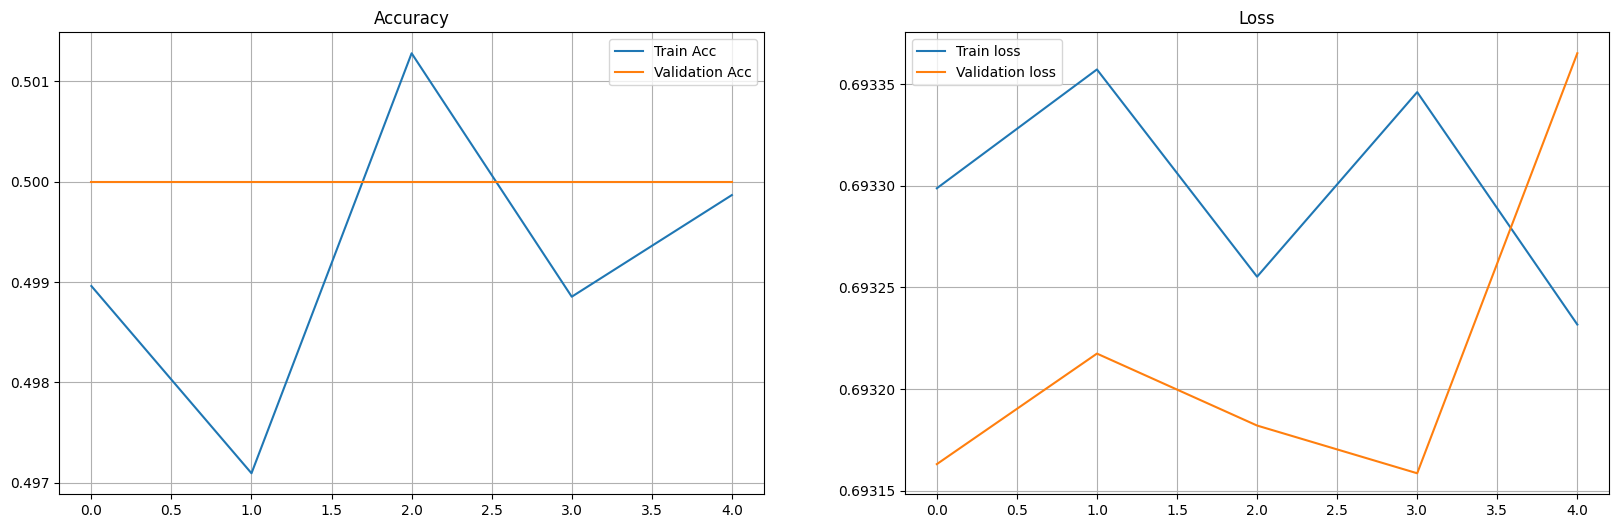

In [25]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [26]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [27]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

NameError: name 'padding_' is not defined